In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
plt.rcParams["font.family"] = "Times New Roman"

In [3]:
stai_scores = np.array(pd.read_csv(r'stai_scores.csv', header=None)[0])
inst_choices = np.array(pd.read_csv(r'inst_choices.csv', header=None))
inst_outcomes = np.array(pd.read_csv(r'inst_outcomes.csv', header=None))

### Data exploration

In [4]:
# Exploring the data: mean, median, standard deviation of STAI
overall_mean = np.mean(stai_scores); print(overall_mean)
overall_std = np.std(stai_scores); print(overall_std)
overall_median = np.median(stai_scores); print(overall_median)

anxious_mean = np.mean(stai_scores[0:25]); print(anxious_mean)
anxious_std = np.std(stai_scores[0:25]); print(anxious_std)
anxious_median = np.median(stai_scores[0:25]); print(anxious_median)

control_mean = np.mean(stai_scores[25:]); print(control_mean)
control_std = np.std(stai_scores[25:]); print(control_std)
control_median = np.median(stai_scores[25:]); print(control_median)
print(sp.stats.ttest_ind(stai_scores[:25], stai_scores[25:], equal_var=False))

42.72
14.730974170094793
40.0
55.24
9.84390166549829
57.0
30.2
4.857983120596448
29.0
Ttest_indResult(statistic=11.174860157303042, pvalue=4.2293214098115444e-13)


In [5]:
# Exploring the data: cut-off = 43, ANXIOUS group if STAI>43
cut_off_stai = np.zeros(len(stai_scores))
for i in range(len(stai_scores)):
    if stai_scores[i] <= 43:
        # cut_off_stai = 1 if the subject is in the healthy control group
        cut_off_stai[i] = 1

healthy_num = sum(cut_off_stai)
healthy_index = np.where(cut_off_stai==1)
print(healthy_num)
print(healthy_index)

29.0
(array([ 3, 15, 16, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),)


In [6]:
# Exploring the data: number of times each subject choosing stimuli A
chose_a_count = []
chose_a_percent = []
for i in range(len(inst_choices)):
    chose_a_count.append(np.array(np.where(inst_choices[i]==1)).size)
    chose_a_percent.append(chose_a_count[-1]/len(inst_choices[i]))
print(chose_a_count)
print(chose_a_percent)
print(np.average(chose_a_count))

[52, 46, 32, 58, 37, 26, 28, 50, 38, 51, 53, 30, 31, 41, 36, 33, 41, 41, 28, 37, 53, 33, 40, 67, 31, 45, 29, 6, 25, 7, 12, 29, 21, 29, 16, 36, 39, 27, 41, 25, 39, 28, 29, 36, 45, 24, 16, 53, 31, 22]
[0.325, 0.2875, 0.2, 0.3625, 0.23125, 0.1625, 0.175, 0.3125, 0.2375, 0.31875, 0.33125, 0.1875, 0.19375, 0.25625, 0.225, 0.20625, 0.25625, 0.25625, 0.175, 0.23125, 0.33125, 0.20625, 0.25, 0.41875, 0.19375, 0.28125, 0.18125, 0.0375, 0.15625, 0.04375, 0.075, 0.18125, 0.13125, 0.18125, 0.1, 0.225, 0.24375, 0.16875, 0.25625, 0.15625, 0.24375, 0.175, 0.18125, 0.225, 0.28125, 0.15, 0.1, 0.33125, 0.19375, 0.1375]
34.46


In [7]:
print(np.where(chose_a_count[0:25]<=np.average(chose_a_count)))
print(np.where(chose_a_count[25:]<=np.average(chose_a_count)))

(array([ 2,  5,  6, 11, 12, 15, 18, 21, 24]),)
(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 12, 14, 16, 17, 20, 21, 23, 24]),)


In [8]:
print(np.average(inst_outcomes))
print(np.average(np.average(inst_outcomes[:25],axis=1)))
print(np.average(np.average(inst_outcomes[25:],axis=1)))

0.384625
0.40275
0.3665


### Simulation


In [9]:
np.random.seed(1)
prob_list = [[0.3,0.7],[0.2,0.8],[0.4,0.6],[0.35,0.65]]

def outcome(a,b,p,V0):
    
    outcome = np.zeros(160)
    choice = []
    value_a = [V0]
    value_b = [V0]
    prob = np.repeat(p,40,axis=0)
    
    for i in range(160):
        p_a = np.exp(-b*value_a[i])/(np.exp(-b*value_a[i])+np.exp(-b*value_b[i]))
        p_b = 1-p_a
        choice.append(np.random.choice([0,1],p=[p_a,p_b]))
        if choice[-1] == 0:
            outcome[i] = np.random.choice([0,1],p=prob[i])
            value_a.append(value_a[-1]+a*(outcome[i]-value_a[-1]))
            value_b.append(value_b[-1])
        else:
            outcome[i] = np.random.choice([0,1],p=1-prob[i])
            value_b.append(value_b[-1]+a*(outcome[i]-value_b[-1]))
            value_a.append(value_a[-1])

    return outcome, choice, value_a, value_b, sum(outcome)


# if correct, 'np.mean(test)' should be around 58
test = []
for i in range(1000):
    test.append(outcome(0.4,7,prob_list,0.5)[-1])
np.mean(test)

58.124

In [10]:
np.random.seed(1)
n = 10000
value_a = np.zeros([n,161])
value_b = np.zeros([n,161])
for i in range(n):
    value_a[i] = outcome(0.4,7,prob_list,0.5)[2]
    value_b[i] = outcome(0.4,7,prob_list,0.5)[3]
value_a = np.mean(value_a,axis=0)
value_b = np.mean(value_b,axis=0)


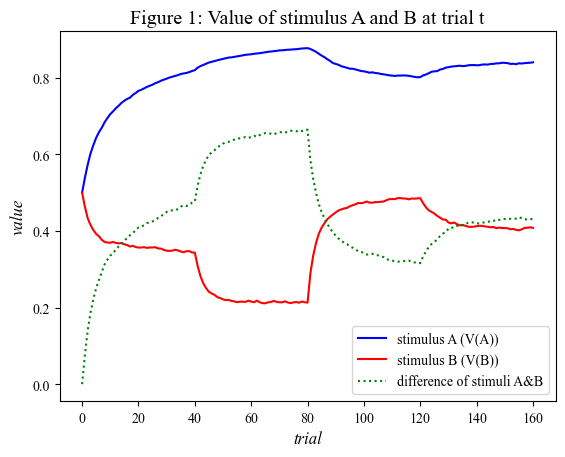

In [11]:
plt.title('Figure 1: Value of stimulus A and B at trial t', fontsize = 'x-large')
plt.plot(value_a, color = 'b', label = "stimulus A (V(A))")
plt.plot(value_b, color = 'r', label = "stimulus B (V(B))")
plt.plot(np.array(value_a)-np.array(value_b), color = 'g', linestyle = 'dotted', label = "difference of stimuli A&B")
plt.xlabel('trial', fontsize = 'large', fontstyle = 'italic')
plt.ylabel('value', fontsize = 'large', fontstyle = 'italic')
plt.legend(loc='lower right')

In [12]:
np.random.seed(1)
num = 20
n = 100
sim_mat = np.zeros([num,num])
alpha = (np.linspace(0,1,num))
beta = (np.linspace(0,10,num))
for i in range(num):
    for j in range(num):
        sim = np.zeros(n)
        for k in range (n):
            sim[k] = outcome(alpha[i],beta[j],prob_list,0.5)[-1]
        sim_mat[i][j] = np.mean(sim)

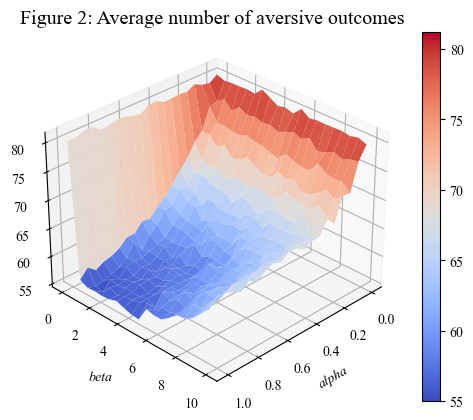

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(30, 45)
X, Y = np.meshgrid(alpha, beta)
plot = ax.plot_surface(X, Y, sim_mat, cmap='coolwarm', vmin=np.min(sim_mat), vmax=np.max(sim_mat))
ax.set_xlabel('alpha',fontstyle = 'italic')
ax.set_ylabel('beta',fontstyle = 'italic')
ax.set_title('Figure 2: Average number of aversive outcomes',fontsize = 'x-large')
fig.colorbar(plot)

plt.show()

### Likelihood function

In [14]:
def nll(params, choices, outcome, V0):
    value_a = [V0]
    value_b = [V0]
    p_a = []
    c_a = np.zeros(len(choices))
    c_a[np.where(choices==1)] = 1
    c_b = np.zeros(len(choices))
    c_b[np.where(choices==2)] = 1
    ll = 0
    a, b = params

    for i in range(len(choices)):
        if choices[i] == 1:
            value_a.append(value_a[-1]+a*(outcome[i]-value_a[-1]))
            value_b.append(value_b[-1])
        else:
            value_b.append(value_b[-1]+a*(outcome[i]-value_b[-1]))
            value_a.append(value_a[-1])

        p_a.append(np.ma.exp(-b*(value_a[i]))*(np.ma.exp(-b*(value_a[i]))+np.ma.exp(-b*(value_b[i])))**(-1))
        ll -= ((np.ma.log(p_a[-1])*c_a[i]) + (np.ma.log((1-p_a[-1]))*c_b[i]))

    return ll

## test should be around 61 
test = nll([0.4,7],inst_choices[8],inst_outcomes[8],0.5); print(test)
nll4 = nll([0.4,7],inst_choices[3],inst_outcomes[3],0.5); print(nll4)
nll5 = nll([0.4,7],inst_choices[4],inst_outcomes[4],0.5); print(nll5)


60.877333438783324
101.6050206224349
52.68861467295329


### Model fitting

In [15]:
fitted_param = []
for i in range(len(stai_scores)):
    fitted_param.append(sp.optimize.minimize(nll,x0=(0.4,7), args=(inst_choices[i],inst_outcomes[i],0.5),method='Nelder-Mead').x)

In [16]:
fitted_alpha, fitted_beta = np.array(fitted_param).T

mean_alpha = np.mean(fitted_alpha); print(mean_alpha)
var_alpha = np.var(fitted_alpha); print(var_alpha)
mean_beta = np.mean(fitted_beta); print(mean_beta)
var_beta = np.var(fitted_beta); print(var_beta)

mean_alpha_anxious = np.mean(fitted_alpha[:25]); print(mean_alpha_anxious)
mean_alpha_control = np.mean(fitted_alpha[25:]); print(mean_alpha_control)
mean_beta_anxious = np.mean(fitted_beta[:25]); print(mean_beta_anxious)
mean_beta_control = np.mean(fitted_beta[25:]); print(mean_beta_control)

print(sp.stats.pearsonr(fitted_alpha, fitted_beta))
print(sp.stats.pearsonr(fitted_alpha[:25], fitted_beta[:25]))
print(sp.stats.pearsonr(fitted_alpha[25:], fitted_beta[25:]))

0.4758865798481678
0.028823177110009483
5.165364859938008
2.7646122988261386
0.5874739980369317
0.36429916165940396
4.655724358126161
5.6750053617498555
PearsonRResult(statistic=-0.2369656492300812, pvalue=0.09753716137988659)
PearsonRResult(statistic=-0.46745261030155233, pvalue=0.01846598704926908)
PearsonRResult(statistic=0.40900638521961774, pvalue=0.04234454107340218)


Text(0.5, 1.0, 'beta')

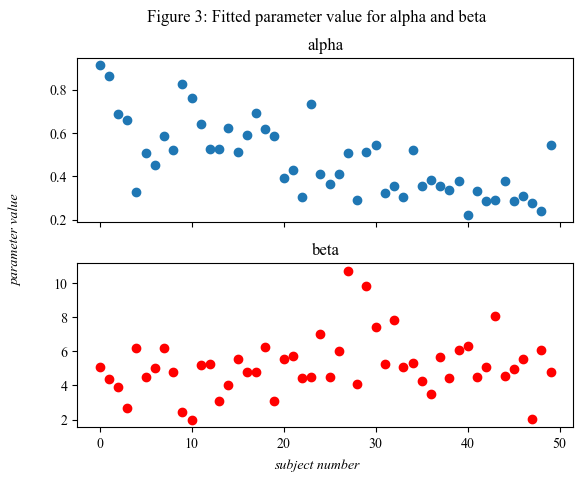

In [18]:
fig, ax = plt.subplots(2, sharex=True)
fig.suptitle('Figure 3: Fitted parameter value for alpha and beta')
fig.text(0.5, 0.03, 'subject number', horizontalalignment ='center', verticalalignment = 'center', fontstyle = 'italic')
fig.text(0.03, 0.5, 'parameter value', horizontalalignment ='center', verticalalignment = 'center', rotation = 'vertical', fontstyle = 'italic')
fig.subplots_adjust(hspace = 0.25)
ax[0].scatter(np.arange(0,50,1),fitted_alpha)
ax[0].set_title('alpha')
ax[1].scatter(np.arange(0,50,1),fitted_beta, color = 'red')
ax[1].set_title('beta')

### Group comparison

In [19]:
dof = len(fitted_alpha[:25]) + len(fitted_alpha[25:]) - 2; print(dof)
print(sp.stats.ttest_ind(fitted_alpha[:25], fitted_alpha[25:], equal_var=False))
print(sp.stats.ttest_ind(fitted_beta[:25], fitted_beta[25:], equal_var=False))

48
Ttest_indResult(statistic=6.042165319443778, pvalue=4.539257722057438e-07)
Ttest_indResult(statistic=-2.2309569492149133, pvalue=0.031110531474266866)


### Parameter recovery

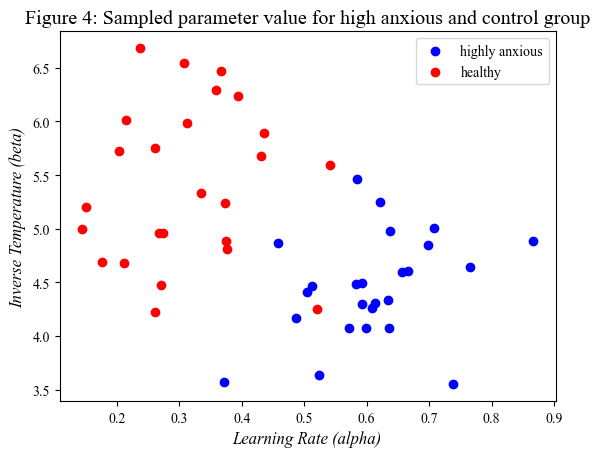

In [20]:
def gaussian(mean_alpha_anxious, mean_beta_anxious,mean_alpha_control, mean_beta_control):
    var_learning_rate = 0.01
    var_inv_temp = 0.5
    cov = 0

    # anxious group
    mean = [mean_alpha_anxious, mean_beta_anxious]
    covariance = [[var_learning_rate, cov], [cov, var_inv_temp]]
    param_values = np.random.multivariate_normal(mean, covariance, 25)

    min_learning_rate = 0
    max_learning_rate = 1
    min_inv_temp = 0
    max_inv_temp = 10

    while True:
        invalid_indices = np.where((param_values[:, 0] < min_learning_rate) | 
                                (param_values[:, 0] > max_learning_rate) | 
                                (param_values[:, 1] < min_inv_temp) |
                                (param_values[:, 1] > max_inv_temp))[0]
        if len(invalid_indices) == 0:
            break
        param_values[invalid_indices] = np.random.multivariate_normal(mean, covariance, len(invalid_indices))


    # control group
    mean = [mean_alpha_control, mean_beta_control]
    covariance = [[var_learning_rate, cov], [cov, var_inv_temp]]
    param_values_c = np.random.multivariate_normal(mean, covariance, 25)

    while True:
        invalid_indices = np.where((param_values_c[:, 0] < min_learning_rate) | 
                                (param_values_c[:, 0] > max_learning_rate) | 
                                (param_values_c[:, 1] < min_inv_temp) |
                                (param_values_c[:, 1] > max_inv_temp))[0]
        if len(invalid_indices) == 0:
            break
        param_values_c[invalid_indices] = np.random.multivariate_normal(mean, covariance, len(invalid_indices))

    return np.concatenate((param_values, param_values_c))

param_values = gaussian(mean_alpha_anxious, mean_beta_anxious,mean_alpha_control, mean_beta_control)

plt.title('Figure 4: Sampled parameter value for high anxious and control group', fontsize = 'x-large')
plt.scatter(param_values[:25, 0], param_values[:25, 1],color = 'b', label = "highly anxious")
plt.scatter(param_values[25:, 0], param_values[25:, 1],color = 'r', label = "healthy")
plt.xlabel('Learning Rate (alpha)',fontsize = 'large', fontstyle = 'italic')
plt.ylabel('Inverse Temperature (beta)',fontsize = 'large', fontstyle = 'italic')
plt.legend(loc='upper right')

In [21]:
def param_sim(param_values):
    sim_choice = []
    sim_outcome = []
    for i in range(50):
        sim_choice.append((outcome(param_values[i][0],param_values[i][1],prob_list,0.5))[1])
        sim_outcome.append((outcome(param_values[i][0],param_values[i][1],prob_list,0.5))[0])

    fitted_param_1 = []
    for i in range(len(stai_scores)):
        fitted_param_1.append(sp.optimize.minimize(nll,x0=(param_values[i][0],param_values[i][1]), args=(sim_choice[i],sim_outcome[i],0.5),method='Nelder-Mead').x)

    fitted_alpha_1, fitted_beta_1 = np.array(fitted_param_1).T
    print(sp.stats.pearsonr(fitted_alpha_1, np.array(param_values).T[0]))
    print(sp.stats.pearsonr(fitted_beta_1, np.array(param_values).T[1]))

PearsonRResult(statistic=0.9999999999999998, pvalue=0.0)
PearsonRResult(statistic=0.9999999999999999, pvalue=0.0)
PearsonRResult(statistic=1.0, pvalue=0.0)
PearsonRResult(statistic=1.0, pvalue=0.0)
PearsonRResult(statistic=1.0, pvalue=0.0)
PearsonRResult(statistic=0.9999999999999997, pvalue=0.0)
PearsonRResult(statistic=1.0, pvalue=0.0)
PearsonRResult(statistic=1.0, pvalue=0.0)
PearsonRResult(statistic=1.0, pvalue=0.0)
PearsonRResult(statistic=1.0, pvalue=0.0)


Text(0.5, 1.0, 'beta')

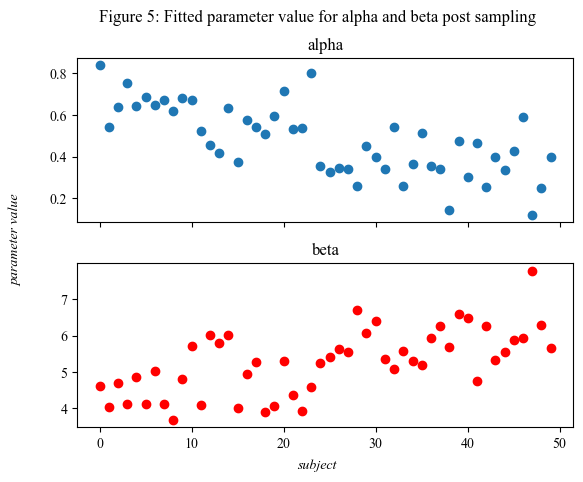

In [22]:
for i in range(5):
    param_values = gaussian(mean_alpha_anxious, mean_beta_anxious,mean_alpha_control, mean_beta_control)
    param_sim(param_values)

fig, ax = plt.subplots(2, sharex=True)
fig.suptitle('Figure 5: Fitted parameter value for alpha and beta post sampling')
fig.text(0.5, 0.03, 'subject', horizontalalignment ='center', verticalalignment = 'center', fontstyle = 'italic')
fig.text(0.03, 0.5, 'parameter value', horizontalalignment ='center', verticalalignment = 'center', rotation = 'vertical', fontstyle = 'italic')
fig.subplots_adjust(hspace = 0.25)
ax[0].scatter(np.arange(0,50,1),np.array(param_values).T[0])
ax[0].set_title('alpha')
ax[1].scatter(np.arange(0,50,1),np.array(param_values).T[1], color = 'red')
ax[1].set_title('beta')

### Alternative model

In [23]:
def outcome_alt(A,a,b,p,V0):
    
    outcome = np.zeros(160)
    choice = []
    value_a = [V0]
    value_b = [V0]
    prob = np.repeat(p,40,axis=0)
    
    for i in range(160):
        p_a = np.exp(-b*value_a[i])/(np.exp(-b*value_a[i])+np.exp(-b*value_b[i]))
        p_b = 1-p_a
        choice.append(np.random.choice([0,1],p=[p_a,p_b]))
        if choice[-1] == 0:
            outcome[i] = np.random.choice([0,1],p=prob[i])
            value_a.append(A*value_a[-1]+a*(outcome[i]-value_a[-1]))
            value_b.append(value_b[-1])
        else:
            outcome[i] = np.random.choice([0,1],p=1-prob[i])
            value_b.append(A*value_b[-1]+a*(outcome[i]-value_b[-1]))
            value_a.append(value_a[-1])

    return outcome, choice, value_a, value_b, sum(outcome)

def nll_alt(params, choices, outcome, V0):
    value_a = [V0]
    value_b = [V0]
    p_a = []
    c_a = np.zeros(len(choices))
    c_a[np.where(choices==1)] = 1
    c_b = np.zeros(len(choices))
    c_b[np.where(choices==2)] = 1
    ll = 0
    A, a, b = params

    for i in range(len(choices)):
        if choices[i] == 1:
            value_a.append(A*value_a[-1]+a*(outcome[i]-value_a[-1]))
            value_b.append(value_b[-1])
        else:
            value_b.append(A*value_b[-1]+a*(outcome[i]-value_b[-1]))
            value_a.append(value_a[-1])

        p_a.append(np.ma.exp(-b*(value_a[i]))*(np.ma.exp(-b*(value_a[i]))+np.ma.exp(-b*(value_b[i])))**(-1))
        ll -= ((np.ma.log(p_a[-1])*c_a[i]) + (np.ma.log((1-p_a[-1]))*c_b[i]))

    return ll

test_alt = []
for i in range(1000):
    test_alt.append(outcome_alt(0.5,0.4,5,prob_list,0.5)[-1])
print(np.mean(test_alt))

test_alt1 = nll_alt([0.5,0.4,5],inst_choices[8],inst_outcomes[8],0.5); print(test_alt1)
nll4_alt = nll_alt([0.5,0.4,5],inst_choices[3],inst_outcomes[3],0.5); print(nll4_alt)
nll5_alt = nll_alt([0.5,0.4,5],inst_choices[4],inst_outcomes[4],0.5); print(nll5_alt)

bounds = ((0,1),(0,1),(0,10))

fitted_param_alt = []
for i in range(len(stai_scores)):
    fitted_param_alt.append(sp.optimize.minimize(nll_alt,x0=(0.5,0.4,5), args=(inst_choices[i],inst_outcomes[i],0.5),method='Nelder-Mead').x)
fitted_a_alt, fitted_alpha_alt, fitted_beta_alt = np.array(fitted_param_alt).T

68.736
68.16237790958874
82.20317887028379
64.15342352148336


/var/folders/k8/kf3w914s7_l6n18t6bqjl9280000gn/T/ipykernel_36138/771713305.py:43: RuntimeWarning: divide by zero encountered in double_scalars
  p_a.append(np.ma.exp(-b*(value_a[i]))*(np.ma.exp(-b*(value_a[i]))+np.ma.exp(-b*(value_b[i])))**(-1))
/var/folders/k8/kf3w914s7_l6n18t6bqjl9280000gn/T/ipykernel_36138/771713305.py:43: RuntimeWarning: invalid value encountered in double_scalars
  p_a.append(np.ma.exp(-b*(value_a[i]))*(np.ma.exp(-b*(value_a[i]))+np.ma.exp(-b*(value_b[i])))**(-1))


Text(0.5, 1.0, 'A (0 < A < 1)')

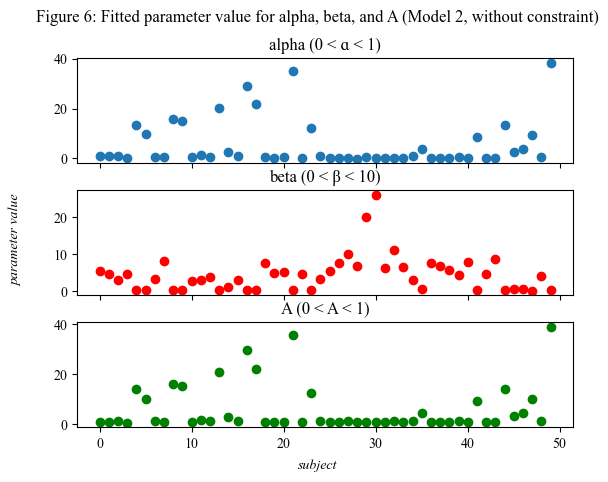

In [24]:
fig, ax = plt.subplots(3, sharex=True)
fig.suptitle('Figure 6: Fitted parameter value for alpha, beta, and A (Model 2, without constraint)')
fig.text(0.5, 0.03, 'subject', horizontalalignment ='center', verticalalignment = 'center', fontstyle = 'italic')
fig.text(0.03, 0.5, 'parameter value', horizontalalignment ='center', verticalalignment = 'center', rotation = 'vertical', fontstyle = 'italic')
fig.subplots_adjust(hspace = 0.25)
ax[0].scatter(np.arange(0,50,1),fitted_alpha_alt)
ax[0].set_title('alpha (0 < ɑ < 1)')
ax[1].scatter(np.arange(0,50,1),fitted_beta_alt, color = 'red')
ax[1].set_title('beta (0 < β < 10)')
ax[2].scatter(np.arange(0,50,1),fitted_a_alt, color = 'green')
ax[2].set_title('A (0 < A < 1)')

Text(0.5, 1.0, 'A (0 < A < 1)')

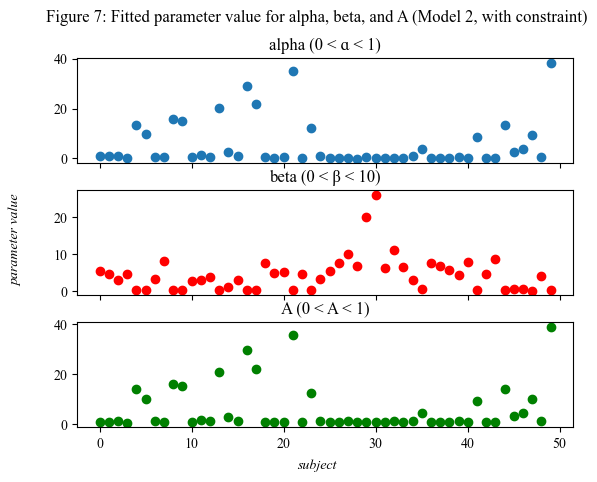

In [25]:
fig, ax = plt.subplots(3, sharex=True)
fig.suptitle('Figure 7: Fitted parameter value for alpha, beta, and A (Model 2, with constraint)')
fig.text(0.5, 0.03, 'subject', horizontalalignment ='center', verticalalignment = 'center', fontstyle = 'italic')
fig.text(0.03, 0.5, 'parameter value', horizontalalignment ='center', verticalalignment = 'center', rotation = 'vertical', fontstyle = 'italic')
fig.subplots_adjust(hspace = 0.25)
ax[0].scatter(np.arange(0,50,1),fitted_alpha_alt)
ax[0].set_title('alpha (0 < ɑ < 1)')
ax[1].scatter(np.arange(0,50,1),fitted_beta_alt, color = 'red')
ax[1].set_title('beta (0 < β < 10)')
ax[2].scatter(np.arange(0,50,1),fitted_a_alt, color = 'green')
ax[2].set_title('A (0 < A < 1)')

### Discussion and extra model

In [29]:
def outcome_ex(ap,an,b,p,V0):
    
    outcome = np.zeros(160)
    choice = []
    value_a = [V0]
    value_b = [V0]
    prob = np.repeat(p,40,axis=0)
    
    for i in range(160):
        p_a = np.exp(-b*value_a[i])/(np.exp(-b*value_a[i])+np.exp(-b*value_b[i]))
        p_b = 1-p_a
        choice.append(np.random.choice([0,1],p=[p_a,p_b]))
        if choice[-1] == 0:
            outcome[i] = np.random.choice([0,1],p=prob[i])
            value_a.append(value_a[-1]+((1-outcome[i])*ap+outcome[i]*an)*(outcome[i]-value_a[-1]))
            value_b.append(value_b[-1])
        else:
            outcome[i] = np.random.choice([0,1],p=1-prob[i])
            value_b.append(value_b[-1]+((1-outcome[i])*ap+outcome[i]*an)*(outcome[i]-value_b[-1]))
            value_a.append(value_a[-1])

    return outcome, choice, value_a, value_b, sum(outcome)

def nll_ex(params, choices, outcome, V0):
    value_a = [V0]
    value_b = [V0]
    p_a = []
    c_a = np.zeros(len(choices))
    c_a[np.where(choices==1)] = 1
    c_b = np.zeros(len(choices))
    c_b[np.where(choices==2)] = 1
    ll = 0
    ap, an, b = params

    for i in range(len(choices)):
        if choices[i] == 1:
            value_a.append(value_a[-1]+((1-outcome[i])*ap+outcome[i]*an)*(outcome[i]-value_a[-1]))
            value_b.append(value_b[-1])
        else:
            value_b.append(value_b[-1]+((1-outcome[i])*ap+outcome[i]*an)*(outcome[i]-value_b[-1]))
            value_a.append(value_a[-1])

        p_a.append(np.ma.exp(-b*(value_a[i]))*(np.ma.exp(-b*(value_a[i]))+np.ma.exp(-b*(value_b[i])))**(-1))
        ll -= ((np.ma.log(p_a[-1])*c_a[i]) + (np.ma.log((1-p_a[-1]))*c_b[i]))

    return ll


bounds = ((0,1),(0,1),(0,10))

fitted_param_ex = []
for i in range(len(stai_scores)):
    fitted_param_ex.append(sp.optimize.minimize(nll_ex,x0=(0.25,0.5,6), args=(inst_choices[i],inst_outcomes[i],0.5),method='Nelder-Mead', bounds = bounds).x)
fitted_ap_ex, fitted_an_ex, fitted_beta_ex = np.array(fitted_param_ex).T

Text(0.5, 1.0, 'beta')

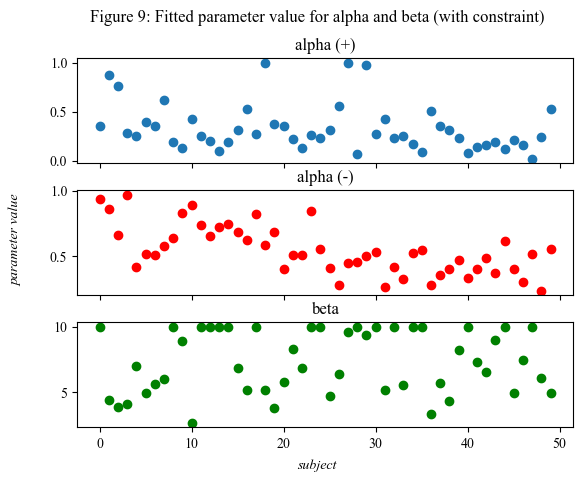

In [30]:
fig, ax = plt.subplots(3, sharex=True)
fig.suptitle('Figure 9: Fitted parameter value for alpha and beta (with constraint)')
fig.text(0.5, 0.03, 'subject', horizontalalignment ='center', verticalalignment = 'center', fontstyle = 'italic')
fig.text(0.03, 0.5, 'parameter value', horizontalalignment ='center', verticalalignment = 'center', rotation = 'vertical', fontstyle = 'italic')
fig.subplots_adjust(hspace = 0.25)
ax[0].scatter(np.arange(0,50,1),fitted_ap_ex)
ax[0].set_title('alpha (+)')
ax[1].scatter(np.arange(0,50,1),fitted_an_ex, color = 'red')
ax[1].set_title('alpha (-)')
ax[2].scatter(np.arange(0,50,1),fitted_beta_ex, color = 'green')
ax[2].set_title('beta')